In [221]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
from PIL import Image
from collections import OrderedDict
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [222]:
list_type = {
 'SMG':'#D36439',
 'GADGET':'#6E778A',
 'RIFLE':'#875859',
 'SHOTGUN':'#7A464D',
 'LMG':'#F3CB5A',
 'GRENADE':'#65606E',
 'SELF-LOADING-RIFLE':'#E1A773',
 'SIDEARM':'#8C7061',
 'TANKER/PILOT':'#CEC9CF',
 'FIELD KIT':'#6B83A3',
 'MELEE':'#ABC6DA'}

def get_colour(dictt, fnd):
    c = dictt[fnd]
    return c

def colour_for_decal(dec):
    lookup = pd.read_csv('../data/raw/bf1_categories_lookup.csv')
    refine = lookup[lookup.Decal == dec]
    name = list(refine.Category)[0]
    c = get_colour(list_type, name)
    return c

def color_decal_type():
    filenames = glob.glob("../data/decals/*.png")
    filepaths_new = []

    for f in filenames:
        f_decal = f.replace('../data/decals/','')
        f_decal = f_decal.replace('.png','')
        c = colour_for_decal(f_decal)
        c = c.lstrip('#')
        rgb_color = tuple(int(c[i:i+2], 16) for i in (0, 2 ,4))
        
        R_OLD, G_OLD, B_OLD = (255, 255, 255)
        R_NEW, G_NEW, B_NEW = rgb_color
        
        im = Image.open(f)
        pixels = im.load()

        width, height = im.size
        for x in range(width):
            for y in range(height):
                r, g, b, a = pixels[x, y]
                if (r, g, b) == (R_OLD, G_OLD, B_OLD):
                    pixels[x, y] = (R_NEW, G_NEW, B_NEW, a)
        fs = f.replace('decals','decals_mod')        
        im.save(fs)
        
def get_weapons(name, cutoff):
    # Load in the data
    df = pd.read_csv('../data/raw/'+ name +'/bf1_weapons.csv')
    df = df.replace('-',0)
    df['Accuracy %'] = df['Accuracy %'].str.rstrip('%').astype('float') / 100.0
    df['Accuracy % Norm'] = np.where(df['Accuracy %'] > 1, 1, df['Accuracy %'])
    df['Kills'] = df['Kills'].astype(int)
    df_used = df[df.Kills > 20]
    print('Number of weapons:',len(df_used))
    df_used = enrich_weapon(df_used)
    df_used = get_colours(df_used)
    return df_used
    
def get_colours(df):
    listm = []
    for key, value in list_type.items():
        temp = [key, value]
        listm.append(temp)
    dt = pd.DataFrame(listm, columns=['Category','Colour'])    
    df = pd.merge(df, dt, on='Category', how='left')
    return df

def enrich_weapon(df):
    lookup = pd.read_csv('../data/raw/bf1_categories_lookup.csv')
    df = pd.merge(df, lookup, on='Name', how='left')
    return df

def imscatter(x, y, image, ax=None, zoom=1):
    image = plt.imread(image)
    im = OffsetImage(image, zoom=zoom)
    ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
    artists =  ax.add_artist(ab)
    return artists

In [223]:
color_decal_type()
df1 = get_weapons('penguin', 20)
df2 = get_weapons('white', 20)

Number of weapons: 28
Number of weapons: 20


In [261]:
def plot_spread(df):
    fig, ax = plt.subplots(figsize=(10,10))
    for index, row in df.iterrows():
        x = row['Accuracy % Norm']
        y = row['Kills']
        image_path = '../data/decals_mod/' + row['Decal'] + '.png'
        imscatter(x, y, image_path, zoom=0.4, ax=ax)
        ax.plot(x, y, label=row['Category'], c=row['Colour'], linewidth=6.5)
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel("Accuracy", fontsize=16, rotation=0)
    plt.xlabel("Kills", fontsize=16)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    ax.xaxis.set_label_position('top') 
    ax.yaxis.set_label_coords(0,0.51)
    
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(2)

    # Removes repeating legend labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),
               frameon=False, fontsize=14, bbox_to_anchor=(1.4, 1))

    sns.despine()
    plt.show()

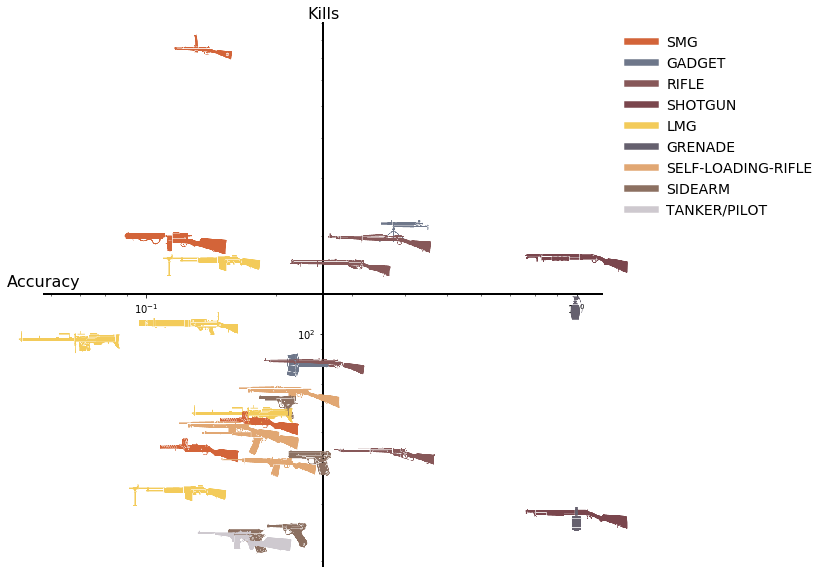

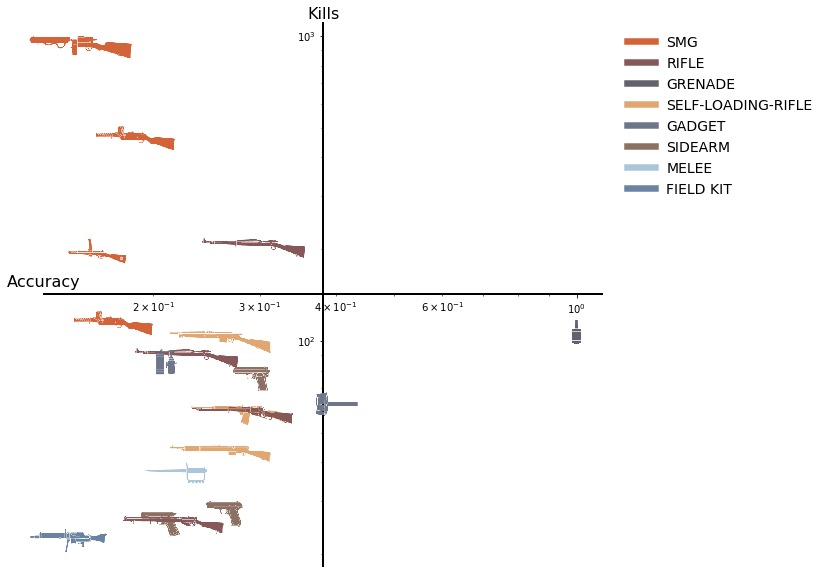

In [262]:
plot_spread(df1)
plot_spread(df2)